In [1]:
import numpy as np
from math import pi, sqrt, tanh
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from ipywidgets import interact
from os import path

# import plotly.graph_objects as go
# import pandas as pd

import time


In [2]:
def Hilbertspace_Zr(N,r):

    states=np.zeros((r**N,N),dtype=int)

    if N>0:
        for i_1 in range(r**N):
            num_str=np.base_repr(i_1,base=r)[::-1]
            for i_2 in range(len(num_str)):
                states[i_1,i_2]=int(num_str[i_2])
    else:
        states=[[0]]
        
    return states

def p_transpose_2(V,Na,Nb):
# partial transpose with respect to subsystem 2
# the basis of NaxNb density matrix is defined by Nb*(i-1)+j,
# i,j=1,2,3 spans the Hilbert space of subsystem 1 and 2 respectively
    U=np.zeros((Na*Nb,Na*Nb), dtype=np.complex128)
    for i_1 in range(Na):
        for i_2 in range(Na):
#             print(V[Nb*i_1:Nb*(i_1+1),Nb*i_2:Nb*(i_2+1)].shape)
            U[Nb*i_1:Nb*(i_1+1),Nb*i_2:Nb*(i_2+1)]=np.transpose(V[Nb*i_1:Nb*(i_1+1),Nb*i_2:Nb*(i_2+1)])

    return U

def vNent_calc(rho,epsilon=1e-9):
    chi0 =np.linalg.eigvalsh(rho)
    chi1=chi0[np.nonzero(np.abs(chi0)>epsilon)]
    chi2=chi1[np.nonzero(np.abs(chi1-1)>epsilon)]
    return -np.sum(chi2*np.log(chi2))


In [74]:
Nrep=1000
r=2 # local Hilbert space dim

La=2
Lb=6
Na=r**La
Nb=r**Lb
symm = 1

Nab_r=r**(La+Lb-1)
s_ab=Hilbertspace_Zr(La+Lb,r)
i_ab=np.zeros((r**(La+Lb-1),r),dtype=int)
### indices of r multiples
for i_Zr in range(r):
    i_ab[:,i_Zr]=np.argwhere(np.mod(np.sum(s_ab,axis=1),r)==i_Zr)[:,0]

L_sw=range(13,14)
# L_sw=range(4*La,21)
# L_sw=[12]

vT=np.zeros((Nrep*Nb*Na,len(L_sw)))
neg=np.zeros((Nrep,len(L_sw)))
vT0=np.zeros((Nrep*Nab_r,len(L_sw)))
vT1=np.zeros((Nrep*Nab_r*(r-1),len(L_sw)))

t_timer= time.time()
for i_l in range(len(L_sw)):
    L=L_sw[i_l]
    print(L)

    Lc=L-La-Lb
    Nc=r**Lc
    
    Nc_r=r**(Lc-1)
    s_c=Hilbertspace_Zr(Lc,r)
    i_c=np.zeros((r**(Lc-1),r),dtype=int)
    ### indices of r multiples
    for i_Zr in range(r):
        i_c[:,i_Zr]=np.argwhere(np.mod(np.sum(s_c,axis=1),r)==i_Zr)[:,0]

    X=np.zeros((Na*Nb,Nc), dtype=np.complex128)

    for i_r in range(Nrep):
        
        X[np.ix_(i_ab[:,0],i_c[:,0])]=np.random.randn(Nab_r,Nc_r)+ 1j*np.random.randn(Nab_r,Nc_r)
#         X[i_ab[:,0],:] = np.random.randn(Ne_ab,Nc)+ 1j*np.random.randn(Ne_ab,Nc)

        mat=np.dot(X,np.matrix(X).H)
        rho= mat / np.trace(mat)

        rT = p_transpose_2(rho,Na,Nb)
#         lT=np.linalg.eigvalsh(rT)
#         vT[i_r*Nb*Na:(i_r+1)*Nb*Na,i_l] = Nab_r *lT
#         neg[i_r,i_l]=np.sum(np.abs(lT))

        rT0= rT[np.ix_(i_ab[:,0],i_ab[:,0])]
        lT0=np.linalg.eigvalsh(rT0)
        vT0[i_r*Nab_r:(i_r+1)*Nab_r,i_l] = Nab_r*lT0

        i_ab_v=np.reshape(i_ab[:,1:],(Nab_r*(r-1),))
        rT1= rT[np.ix_(i_ab_v,i_ab_v)]
        lT1=np.linalg.eigvalsh(rT1)
        vT1[i_r*Nab_r*(r-1):(i_r+1)*Nab_r*(r-1),i_l] = Nab_r*lT1

        
    out_dir = 'data/' 
    if symm==1:
        f1= 'NS_proj_decomp_r_%d_Labc_%d_%d_%d_symm.npz' % (r,La,Lb,Lc)
    else:
        f1= 'NS_proj_decomp_r_%d_Labc_%d_%d_%d.npz' % (r,La,Lb,Lc)
    fname = out_dir+ f1
    np.savez(fname, e1=vT1[:,i_l], e0=vT0[:,i_l], Nrep=Nrep)

elapsed = time.time() - t_timer
print("Finished, elapsed time = %.2f " % (elapsed)+ "sec")

13
Finished, elapsed time = 7.31 sec


ES was loaded!


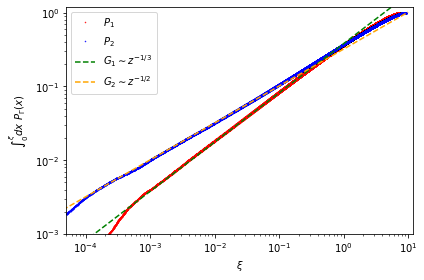

In [132]:
out_dir = "/gscratch/home/hshapourian/RMT/data/" #'data/' 

r = 3
La=2
Lb=6
Na=r**La
Nb=r**Lb
symm = 1
L_sw=[13]

plt.figure()

for i_l in range(len(L_sw)):
    L=L_sw[i_l]
    Lc=L-La-Lb

    if symm==1:
        f1= 'NS_proj_decomp_r_%d_Labc_%d_%d_%d_symm.npz' % (r,La,Lb,Lc)
    else:
        f1= 'NS_proj_decomp_r_%d_Labc_%d_%d_%d.npz' % (r,La,Lb,Lc)
    fname = out_dir+f1

    npzfile = np.load(fname)
    Nrep=npzfile['Nrep']
    vT0=npzfile['e0']
    vT1=npzfile['e1']
    print('ES was loaded!')
    n_sum=Nrep*Na*Nb

    
#     n, bin_edges = np.histogram(vT[:,i_l], bins=num_bins)
#     bins_center= (bin_edges[0:num_bins]+ bin_edges[1:])/2
#     n= n/n_sum/(bin_edges[1]-bin_edges[0])
        
#     plt.plot(bins_center,n,'-',markersize=2,color='C%d' % (i_l))

#     num_bins1=2000
#     n0, bin_edges0 = np.histogram(vT0, bins=num_bins1)
#     bins_center0= (bin_edges0[0:num_bins1]+ bin_edges0[1:])/2
#     n0= n0/n_sum/(bin_edges0[1]-bin_edges0[0])

#     n1, bin_edges1 = np.histogram(vT1, bins=num_bins1)
#     bins_center1= (bin_edges1[0:num_bins1]+ bin_edges1[1:])/2
#     n1= n1/n_sum/(bin_edges1[1]-bin_edges1[0])

# #     vc=np.concatenate((vT0,vT1))
# #     nc, bin_edgesc = np.histogram(vc[:,i_l], bins=num_bins)
# #     bins_centerc= (bin_edgesc[0:num_bins]+ bin_edgesc[1:])/2
# #     nc= nc/n_sum/(bin_edgesc[1]-bin_edgesc[0])
    
# #     plt.plot(bins_center,nc,'o',markersize=4,markerfacecolor="None",label=r"$N_B=%d $" % (Lc))
#     plt.plot(bins_center0,n0*r,'o',markersize=2,label=r"$G_2$")#,color='C%d' % (i_l),label=r"$N_B=%d $" % (Lc))
#     plt.plot(bins_center1,n1*r/(r-1),'v',markersize=4,label=r"$G_1$")#,color='C%d' % (i_l))

    msize = 1
    vT1 = np.sort(vT1)
    ind_p = np.argwhere(vT1>0)
    vT1p = vT1[ind_p[0][0]:]
    vs = np.sort(vT1p)
    plt.plot(vs,np.linspace(1/len(vT1p),1,len(vT1p)) ,"r.",markersize=msize,label=r"$P_1$")
    vT0 = np.sort(vT0)
    ind_p = np.argwhere(vT0>0)
    vT0p = vT0[ind_p[0][0]:]
    vs = np.sort(vT0p)
    plt.plot(vs,np.linspace(1/len(vT0p),1,len(vT0p)) ,"b.",markersize=msize,label=r"$P_2$")

xx = np.logspace(-5,1)
plt.plot(xx,0.38*xx**(2/3),"g--",label=r"$G_1\sim z^{-1/3}$")
plt.plot(xx,0.32*xx**0.5,"--",color="orange",label=r"$G_2\sim z^{-1/2}$")

plt.ylabel(r"$\int_0^\xi dx\ P_\Gamma(x)$")
plt.xlabel(r"$\xi$")
plt.xscale("log")
plt.yscale("log")
plt.ylim(1e-3,1.2)
plt.xlim(5e-5,1.2e1)
plt.legend()
plt.tight_layout()

plt.savefig('figs/Z%d_critical_log_Labc_%d_%d_%d_symm.pdf' % (r,La,Lb,Lc))

plt.show()

# db0=bins_center0[-1]-bins_center0[0]
# db1=bins_center1[-1]-bins_center1[0]

# print('vertical ratio: ',np.max(n1)/np.max(n0))
# print('horizontal ratio: ',db1/db0)
# print(n_sum-Nrep*Na*Nb)

ES was loaded!


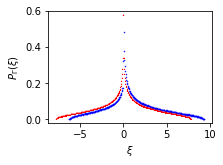

In [131]:
out_dir = "/gscratch/home/hshapourian/RMT/data/" #'data/' 

r = 3
La=2
Lb=6
Na=r**La
Nb=r**Lb
symm = 1
L_sw=[13]

plt.figure(figsize=(3.2,2.4))

for i_l in range(len(L_sw)):
    L=L_sw[i_l]
    Lc=L-La-Lb

    if symm==1:
        f1= 'NS_proj_decomp_r_%d_Labc_%d_%d_%d_symm.npz' % (r,La,Lb,Lc)
    else:
        f1= 'NS_proj_decomp_r_%d_Labc_%d_%d_%d.npz' % (r,La,Lb,Lc)
    fname = out_dir+f1

    npzfile = np.load(fname)
    Nrep=npzfile['Nrep']
    vT0=npzfile['e0']
    vT1=npzfile['e1']
    print('ES was loaded!')
    n_sum=Nrep*Na*Nb

    
#     n, bin_edges = np.histogram(vT[:,i_l], bins=num_bins)
#     bins_center= (bin_edges[0:num_bins]+ bin_edges[1:])/2
#     n= n/n_sum/(bin_edges[1]-bin_edges[0])
        
#     plt.plot(bins_center,n,'-',markersize=2,color='C%d' % (i_l))

    num_bins1=400
    n0, bin_edges0 = np.histogram(vT0, bins=num_bins1)
    bins_center0= (bin_edges0[0:num_bins1]+ bin_edges0[1:])/2
    n0= n0/n_sum/(bin_edges0[1]-bin_edges0[0])

    n1, bin_edges1 = np.histogram(vT1, bins=num_bins1)
    bins_center1= (bin_edges1[0:num_bins1]+ bin_edges1[1:])/2
    n1= n1/n_sum/(bin_edges1[1]-bin_edges1[0])

#     vc=np.concatenate((vT0,vT1))
#     nc, bin_edgesc = np.histogram(vc[:,i_l], bins=num_bins)
#     bins_centerc= (bin_edgesc[0:num_bins]+ bin_edgesc[1:])/2
#     nc= nc/n_sum/(bin_edgesc[1]-bin_edgesc[0])
    
#     plt.plot(bins_center,nc,'o',markersize=4,markerfacecolor="None",label=r"$N_B=%d $" % (Lc))
    plt.plot(bins_center0,n0*r,'bo',markersize=0.5,label=r"$P_2$")#,color='C%d' % (i_l),label=r"$N_B=%d $" % (Lc))
    plt.plot(bins_center1,n1*r/(r-1),'rv',markersize=0.5,label=r"$P_1$")#,color='C%d' % (i_l))

plt.ylabel(r"$P_\Gamma(\xi)$")
plt.xlabel(r"$\xi$")
# plt.xscale("log")
# plt.yscale("log")
plt.ylim(-0.02,.6)
# plt.xlim(5e-5,2e1)
# plt.legend()
plt.tight_layout()
plt.savefig('figs/Z%d_critical_Labc_%d_%d_%d_symm.pdf' % (r,La,Lb,Lc))

plt.show()



# log negativity

In [ ]:
Nrep=10
r=2 # local Hilbert space dim

L=12
La_sw=range(1,int(L/2)+1)
# La_sw= [1] # range(1,6) 

dims = [r] * L
N = prod(dims)

s_abc=Hilbertspace_Zr(L,r)

Ne_abc = r**(L-1)

t_timer=time.time()

neg_symm=np.zeros((len(La_sw),Nrep))
neg_full=np.zeros((len(La_sw),Nrep))
# np.random.seed(1)

for i_l in range(len(La_sw)):
    
    La=La_sw[i_l]
    Lb=La
    Lc=L-La-Lb
    print(' ',La)
    
    Na=r**La
    Nb=r**Lb
    dims_ab = [r] * (La+Lb)
    Nc=r**Lc
    
    if Lc>0:
        Ne_ab = r**(L-2)
    else:
        Ne_ab = r**(L-1)

    i_abc=np.zeros((Ne_abc,r),dtype=int)
    i_c=np.zeros((Ne_ab,r),dtype=int)
    ### indices of r multiples
    for i_Zr in range(r):
        if Lc>0:
            i_abc[:,i_Zr]=np.argwhere(np.mod(np.sum(s_abc[:,:(La+Lb)],axis=1),r)==i_Zr)[:,0]
            i_v=np.argwhere(np.mod(np.sum(s_abc[i_abc[:,i_Zr],(La+Lb):],axis=1),r)==i_Zr)[:,0]
            i_c[:,i_Zr]=i_abc[i_v,i_Zr]
        else:
            i_c[:,i_Zr]=np.argwhere(np.mod(np.sum(s_abc,axis=1),r)==i_Zr)[:,0]

    for i_r in range(Nrep):
#         print(i_r,end='\r')
        
        psi = rand_ket(N)
        neg_full[i_l,i_r]=logneg_subsys_approx(psi, dims=dims, sysa=np.arange(Lc,Lc+La), sysb=np.arange(Lc+La,L))

# #         vec=np.random.randn(Ne_abc)+ 1j*np.random.randn(Ne_abc)
# #         psi[i_abc[:,0]]=vec/np.linalg.norm(vec)

        vec=np.random.randn(Ne_ab)+ 1j*np.random.randn(Ne_ab)
        psi = np.zeros(N, dtype=np.complex128)
        psi[i_c[:,0]]=vec/np.linalg.norm(vec)

#         X=np.reshape(psi,(Nc,Na*Nb)).T
#         mat=np.dot(X,np.matrix(X).H)
#         rho= mat / np.trace(mat)    
#         print(rho)

#         rho_ab = ptr(psi, dims=dims, keep=np.arange(Lc,L))
#         rho_ab = ptr(psi, dims=dims, keep=[1,2])
#         print(rho_ab-rho)
        
#         rT = p_transpose_2(rho,Na,Nb)
#         l1T=np.linalg.eigvalsh(rT)
#         negb[i_l,i_r]=np.log2(np.sum(np.abs(l1T)))

    #     neg_q[i_r]=logneg( rho_ab, dims=dims_ab, sysa=np.arange(La) )
    # #     neg_q[i_r]=logneg_subsys(psi, dims=dims, sysa=np.arange(La), sysb=np.arange(La,La+Lb))
    #     print(neg_q[i_r])

        neg_symm[i_l,i_r]=logneg_subsys_approx(psi, dims=dims, sysa=np.arange(Lc,Lc+La), sysb=np.arange(Lc+La,L))
    #     print(neg_q[i_r])
    
    print(i_r)


elapsed = time.time() - t_timer
print("Finished, quimb elapsed time = %.2f " % (elapsed)+ "sec")

# print(neg_q)

  1
9
  2
9
  3
9
  4
9
  5


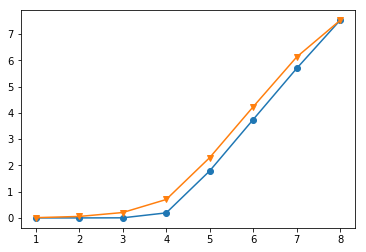

In [19]:
neg_full_avg=np.mean(neg_full,axis=1)
neg_symm_avg=np.mean(neg_symm,axis=1)
plt.figure()
plt.plot(La_sw,neg_full_avg,'o-')
plt.plot(La_sw,neg_symm_avg,'v-')
plt.show()

In [ ]:
neg_avg1=np.mean(neg_q,axis=1)
print(neg_avg1)
plt.figure()
plt.plot(La_sw,neg_avg1,'o-')
# plt.plot(La_sw,negb,'v')
plt.show()

In [ ]:
Nrep=1
r=2 # local Hilbert space dim
symm=1

Labc=16
Lc_sw=np.arange(1,Labc)


for Lc in Lc_sw:
    Nc=r**Lc
    Lab = Labc-Lc
    Nab = r**Lab
    print("Lc: ", Lc)
    X=np.zeros((Nab,Nc), dtype=np.complex128)

    if symm==1:
        Nab_r=r**(Lab-1)
        s_ab=Hilbertspace_Zr(Lab,r)
        i_ab=np.zeros((r**(Lab-1),r),dtype=int)
        ### indices of r multiples
        for i_Zr in range(r):
            i_ab[:,i_Zr]=np.argwhere(np.mod(np.sum(s_ab,axis=1),r)==i_Zr)[:,0]

        Nc_r=r**(Lc-1)
        s_c=Hilbertspace_Zr(Lc,r)
        i_c=np.zeros((r**(Lc-1),r),dtype=int)
        ### indices of r multiples
        for i_Zr in range(r):
            i_c[:,i_Zr]=np.argwhere(np.mod(np.sum(s_c,axis=1),r)==i_Zr)[:,0]

    ln_vals=np.zeros((Nrep,Lab+1))

    t_timer= time.time()
    for i_r in range(Nrep):
        print(i_r)
        if symm==1:
            X[np.ix_(i_ab[:,0],i_c[:,0])]=np.random.randn(Nab_r,Nc_r)+ 1j*np.random.randn(Nab_r,Nc_r)
        else:
        #### no symmetry
            X=np.random.randn(Nab,Nc)+1j*np.random.randn(Nab,Nc_r)

        mat=np.dot(X,np.matrix(X).H)
        rho= mat / np.trace(mat)
        for La in range(Lab+1):
            Lb = Labc-Lc-La
            ln_vals[i_r,La]= logneg(rho,dims=[r]*(Lab),sysa=range(La))


    out_dir = 'data/' 
    
    for La in range(Lab+1):
        Lb = Labc-Lc-La
        if symm==1:
            f1= 'LN_Z%d_Labc_%d_%d_%d_symm.npz' % (r,La,Lb,Lc)
        else:
            f1= 'LN_Z%d_Labc_%d_%d_%d.npz' % (r,La,Lb,Lc)
        print(f1+' was saved!')
        fname = out_dir+f1
        np.savez(fname, ln_vals=ln_vals[:,La], Nrep=Nrep)
    elapsed = time.time() - t_timer
    print("Finished, elapsed time = %.2f " % (elapsed)+ "sec")
#     print(ln_vals2)
#     print(ln_vals)


Lc:  1
0


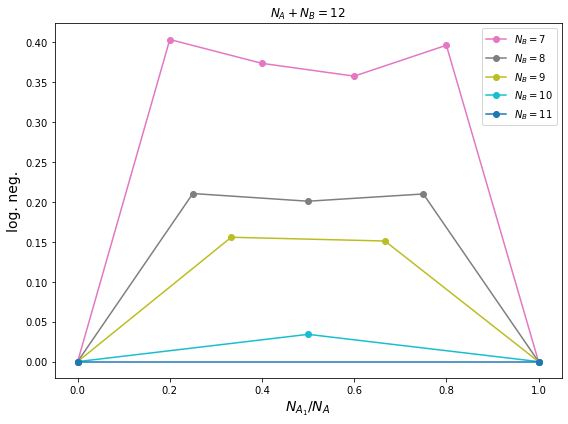

In [6]:
out_dir = 'data/' 
r=2 # local Hilbert space dim
symm=1


Labc_list = [12]

plt.figure(figsize=(8,6))

for Labc in Labc_list:
#     Npt = int(Labc/2)
    for Lc in range(7,Labc):
        Lab = Labc-Lc
        ln_avg= np.zeros(Lab+1)
        mi_avg= np.zeros(Lab+1)
        for La in range(1,Lab):
            Lb = Labc-Lc-La
            if symm==1:
                f1= 'LN_Z%d_Labc_%d_%d_%d_symm.npz' % (r,La,Lb,Lc)
            else:
                f1= 'LN_Z%d_Labc_%d_%d_%d.npz' % (r,La,Lb,Lc)
            fname = out_dir+f1

            npzfile = np.load(fname)
            ln_vals=npzfile['ln_vals']
            ln_avg[La] = np.mean(ln_vals)
#             mi_vals=npzfile['mi_vals']
#             mi_avg[La] = np.mean(mi_vals)
        plt.plot(np.arange(Lab+1)/Lab,ln_avg,"o-",color="C%d" % (Lc-1),label=r"$N_B=%d$" % (Lc))
#         plt.plot(np.arange(Lab+1)/Lab,0.5*mi_avg,"v-",color="C%d" % (Lc-1))
        if Lab>Lc-2:
            N_La = 40
            La_list = np.linspace(0.01,0.99,N_La)*Lab
            ln_ref= np.zeros(N_La)
            for i_a in range(N_La):
                La = La_list[i_a]
                Lb = Labc-Lc-La
                if La<Lb:
                    Na = 2**La
                    Nb = 2**Lb
                    Nc = 2**Lc
                else:
                    Na = 2**Lb
                    Nb = 2**La
                    Nc = 2**Lc
                a = Nc/Nb +1j*0
                b = Nc/Nb*Na +1j*0
                ln_ref[i_a]=np.log2(neg_calc(a,b)*(Nb*Na)/pi/(Na*Nc))

    # #             f1= 'LN_%d_Labc_%d_%d_%d.npz' % (Npt,La,Lb,Lc)
    #             f1= 'LN_Labc_%d_%d_%d.npz' % (La,Lb,Lc)
    #             fname = out_dir+f1

    #             npzfile = np.load(fname)
    #             ln_vals=npzfile['ln_vals']
    #             ln_avg_ref[La] = np.mean(ln_vals)
#             plt.plot(La_list/Lab,ln_ref,"--",color="C%d" % (Lc-1))


# lw=0.2
# ymax=0.3
# plt.plot( [0,0],[0,ymax],'k--',linewidth=lw)
# # plt.xscale("log")
# # plt.yscale("log")
# # plt.ylim(-0.01,ymax)
# # plt.xlim(-0.1,1)
# # plt.yticks(np.arange(0.,ymax+0.1,0.5))
plt.legend()
fsize=14
plt.xlabel(r'$N_{A_1}/N_A$',fontsize = fsize)
plt.ylabel("log. neg.",fontsize = fsize)
plt.title(r'$N_A+N_B = %d$' % (Labc))

plt.tight_layout()
# if symm==1:
#     plt.savefig('figs/NS_r_%d_LA_%d_symm.pdf' % (r,La+Lb))
# else:
#     plt.savefig('figs/NS_r_%d_LA_%d.pdf' % (r,La+Lb))
plt.show()

In [ ]:
negb_avg=np.mean(negb,axis=1)
plt.figure()
plt.plot(La_sw,neg_avg,'o-')
plt.plot(La_sw,negb_avg,'v')
plt.show()

In [14]:
# bipartite entanglement

Nrep=1000
r=5 # local Hilbert space dim

La=3
Lb=0
L=2*La
Lc=L-La-Lb

Na=r**La
Nb=r**Lb
Nc=r**Lc

s_c=Hilbertspace_Zr(Lc,r)
s_ab=Hilbertspace_Zr(La+Lb,r)

i_ab=np.zeros((r**(La+Lb-1),r),dtype=int)
i_c=np.zeros((r**(Lc-1),r),dtype=int)
### indices of r multiples
for i_r in range(r):
    i_c[:,i_r]=np.argwhere(np.mod(np.sum(s_c,axis=1),r)==i_r)[:,0]
    i_ab[:,i_r]=np.argwhere(np.mod(np.sum(s_ab,axis=1),r)==i_r)[:,0]

Nab_r=int(Nb*Na/r)
Nc_r=r**(Lc-1)
X=np.zeros((Na*Nb,Nc), dtype=np.complex128)

ent0=np.zeros(Nrep)
ent1=np.zeros(Nrep)

for i_r in range(Nrep):
    #### no symmetry
    X0=np.random.randn(Na*Nb,Nc)+1j*np.random.randn(Na*Nb,Nc)
    mat=np.dot(X0,np.matrix(X0).H)
    rho= mat / np.trace(mat)    
    ent0[i_r]=vNent_calc(rho)

    X[np.ix_(i_ab[:,0],i_c[:,0])]=np.random.randn(Nab_r,Nc_r)+ 1j*np.random.randn(Nab_r,Nc_r)
    for i_Zr in np.arange(1,r):
        X[np.ix_(i_ab[:,i_Zr],i_c[:,r-i_Zr])]=np.random.randn(Nab_r,Nc_r)+1j*np.random.randn(Nab_r,Nc_r)

#     X[np.ix_(i_ab[:,0],i_c[:,0])]=np.random.randn(Nab_r,Nc_r)+ 1j*np.random.randn(Nab_r,Nc_r)
#     X[np.ix_(i_ab[:,1],i_c[:,1])]=np.random.randn(Nab_r,Nc_r)+ 1j*np.random.randn(Nab_r,Nc_r)
    mat=np.dot(X,np.matrix(X).H)
    rho= mat / np.trace(mat)    
    ent1[i_r]=vNent_calc(rho)
    
print(np.mean(ent0))
print(np.mean(ent1))
print(np.log(Na)-0.5)

4.328390084765682
4.328744035803526
4.3283137373023015


In [ ]:
# rho.shape
# X.shape
# i_ab[:,0]
# np.linalg.eigvalsh(rho)